In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,3)

In [2]:
srate = 1000
# changed time from [-1,1] to [-2,2] to get a better guassian resolution
time = np.linspace(start = -2, stop = 2, num = 1000)
freq = 2 * np.pi

In [3]:
# using euler's to ceneter the sine at zero (it looks okay)
sine_wave = np.cos(2 * np.pi * freq * time) - 0.1 * np.sin(2 * np.pi * freq * time)

In [4]:
def plot_signal(x, y, title, x_label = "Time", y_label = "Amplitude", zoom = "no"):
    plt.plot(x, y, color = "#9F0D06")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, which='both')
    # plt.axhline(y=0, color='k')
    if zoom == "yes":
        plt.margins(x=0, y=-0.001)
        plt.xlim(0,40)
    plt.show()

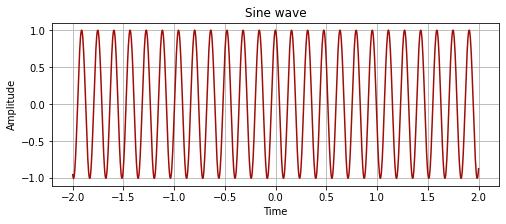

In [5]:
plot_signal(time, sine_wave, "Sine wave")

We want to create a guassian with a full width at half maximum (FWHM), where the FWHM is the width of a line shape at half of its maximum amplitude, as shown below:

![png](FWHM.svg)

In [6]:
# defining the gaussian
# full width at half maximum
fwhm = 0.5
gaussian = np.exp((-4 * np.log(2) * (time)**2) / (fwhm**2))

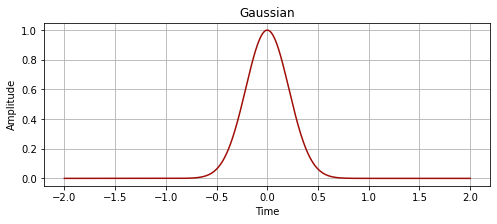

In [7]:
plot_signal(time, gaussian, "Gaussian")

In [8]:
# element-wise multiplication of the sine and gaussian
morlet_wavelet = sine_wave * gaussian

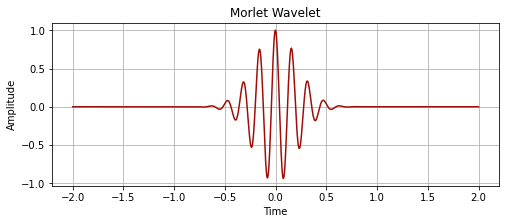

In [9]:
plot_signal(time, morlet_wavelet, "Morlet Wavelet")

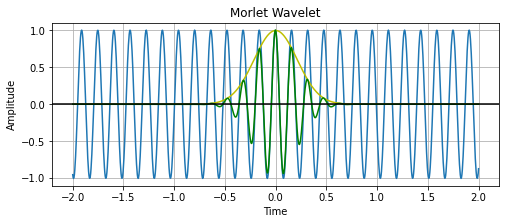

In [10]:
# looking at everything at once.
plt.plot(time, sine_wave)
plt.plot(time, gaussian, 'y')
plt.plot(time, morlet_wavelet, 'g')
plt.title('Morlet Wavelet')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.show()

In [11]:
pnts = time.shape[0]
mwX = 2 * abs(np.fft.fft(morlet_wavelet)/pnts)
hz = np.linspace(start = 0, stop = srate, num = pnts)

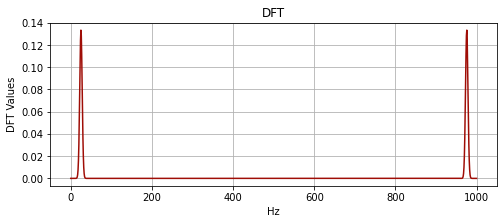

In [12]:
plot_signal(hz, mwX, "DFT", "Hz", "DFT Values")

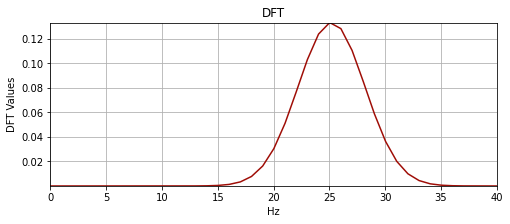

In [13]:
plot_signal(hz, mwX, "DFT", "Hz", "DFT Values", "yes")

In [14]:
import pandas as pd

time_series = pd.read_csv("data.csv")
time_series_values = time_series["value"].to_numpy()

In [15]:
time_series_values = np.append(time_series_values, time_series_values)
time_series_values = np.append(time_series_values, time_series_values)
time_series_values = np.append(time_series_values, time_series_values)

In [16]:
time_series_time = np.linspace(start = 0, stop = 100, num = len(time_series_values))

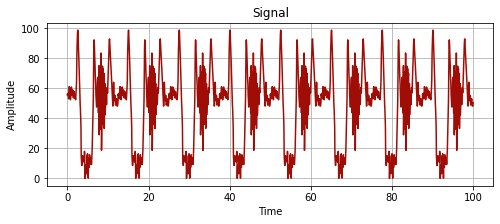

In [17]:
plot_signal(time_series_time, time_series_values, "Signal")

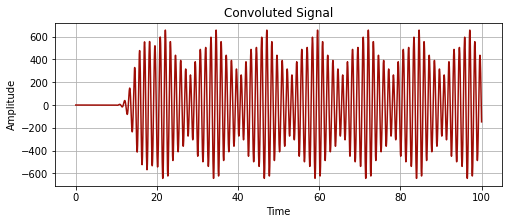

In [18]:
convoluted_signal = np.convolve(time_series_values, morlet_wavelet, 'full')
plot_signal(time_series_time, convoluted_signal[:len(time_series_time)], "Convoluted Signal")

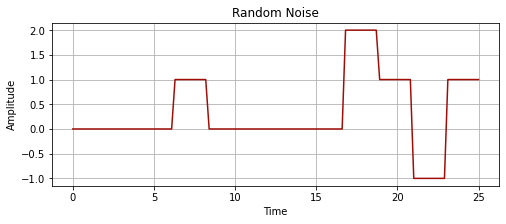

In [19]:
x1 = np.zeros(30)
x2 = np.ones(10)
x3 = np.zeros(40)
x4 = np.ones(10)*2
x5 = np.ones(10)*-1
time_series_values_2 = np.array([])

time_series_values_2 = np.append(time_series_values_2, x1)
time_series_values_2 = np.append(time_series_values_2, x2)
time_series_values_2 = np.append(time_series_values_2, x3)
time_series_values_2 = np.append(time_series_values_2, x4)
time_series_values_2 = np.append(time_series_values_2, x2)
time_series_values_2 = np.append(time_series_values_2, x5)
time_series_values_2 = np.append(time_series_values_2, x2)

time_series_time_2 = np.linspace(0, 25, len(time_series_values_2))

plot_signal(time_series_time_2, time_series_values_2, "Random Noise")

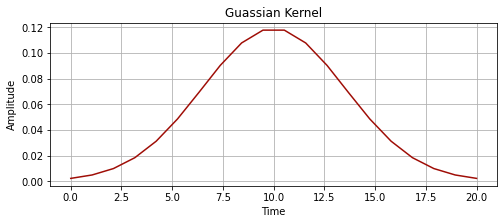

In [20]:
kernel_new = np.exp(-np.linspace(-2,2,20)**2)
kernel_new = kernel_new / np.sum(kernel_new)
# try these
# kernel_new = -1 * kernel_new
kernel_time = np.linspace(0, 20, 20)
plot_signal(kernel_time, kernel_new, "Guassian Kernel")

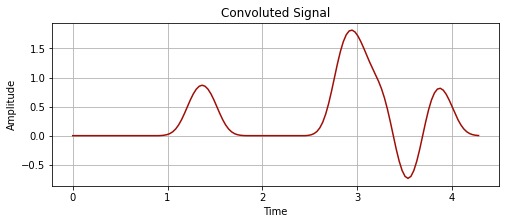

In [21]:
# smooths out the signal
convoluted_signal = np.convolve(time_series_values_2, kernel_new, 'full')
plot_signal(time_series_time[:len(convoluted_signal)], convoluted_signal, "Convoluted Signal")

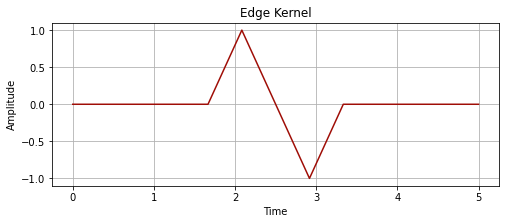

In [22]:
# let's try building the edge detecting kernel

kernel_edge = np.array([])
x6 = np.zeros(5)
x7 = np.ones(1)
x8 = np.zeros(1)
x9 = np.ones(1) * -1

kernel_edge = np.append(kernel_edge, x6)
kernel_edge = np.append(kernel_edge, x7)
kernel_edge = np.append(kernel_edge, x8)
kernel_edge = np.append(kernel_edge, x9)
kernel_edge = np.append(kernel_edge, x6)

kernel_time_edge = np.linspace(0, 5, len(kernel_edge))
plot_signal(kernel_time_edge, kernel_edge, "Edge Kernel")

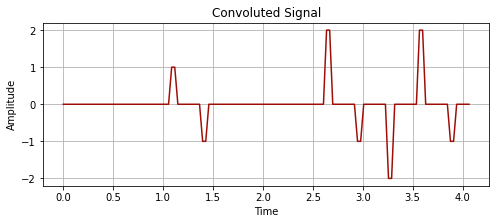

In [23]:
# signed edge detecting kernel
convoluted_signal = np.convolve(time_series_values_2, kernel_edge, 'full')
plot_signal(time_series_time[:len(convoluted_signal)], convoluted_signal, "Convoluted Signal")

In [24]:
# step 1: n's of convolution
# define all the sizes

n_data = len(time_series_time_2)
n_kern = len(kernel_new)
n_conv = n_data + n_kern - 1
half_k = math.floor(n_kern / 2)

# step 2: FFTs
# in the next we need to perform an element-wise multiplication
# so we need to set both their sizes to n_conv
# make sure to properly zero pad
# rfft: Compute the one-dimensional discrete Fourier Transform for real input.
fft_signal_x = np.fft.rfft(time_series_time_2, n_conv)
fft_kernel_x = np.fft.rfft(kernel_new, n_conv)

In [25]:
# step 3: element-wise multiplication
convres_x = fft_signal_x * fft_kernel_x

# step 4: IFFT
convres = np.fft.irfft(convres_x)

# step 5: cut off the wings
convres = convres[half_k+1:len(convres)+1]

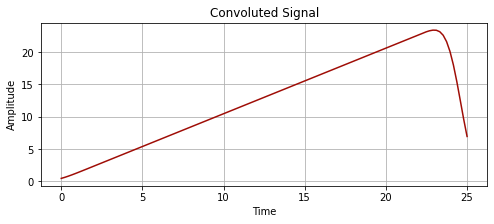

In [26]:
# there's some problem here

plot_signal(time_series_time_2, convres[:len(time_series_time_2)], "Convoluted Signal")

Links:

[graph stuff](https://pythontic.com/visualization/charts/sinewave)
[time-series-or-signal-in-python](https://stackoverflow.com/questions/36286566/how-to-generate-noisy-mock-time-series-or-signal-in-python)
[random time series generator](http://mbonvini.github.io/TimeSeriesMaker/)
[Edge Detecting Kernel](https://www.cs.princeton.edu/courses/archive/fall08/cos429/lecture_linear_filters_edge_detection.pdf)
[](https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm)